#### Imports and generic functions

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_extra.cluster import KMedoids
import copy

In [2]:
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
# green = (0.31, 1, 0.34) # (79, 255, 87)
green = (0.122, 00.816, 0.51) # (31, 208, 130)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)
cgreen = (0.57254902, 0.7254902 , 0.51372549) # (146, 185, 131)
cblue = (0.70196078, 0.83137255, 1) # (179, 212, 255)

top_domain = 53.32 # 90% quantile

def get_hydro_opt(d, lh, ls, lb, max_elec):
    # Get optimal adjustment at given balancing prices
    if ls > lh:
        return 0
    elif lb < lh:
        return max_elec
    else:
        return np.minimum(max_elec, np.maximum(0, d))

def import_consts(negative_prices=False):
    # import data and set constants
    all_data = pd.read_csv("./data/2020_data.csv")
    prices_B = np.maximum(all_data["UP"].to_numpy(),0)
    prices_S = np.maximum(all_data["DW"].to_numpy(),0)
    prices_F = np.maximum(all_data["forward_RE"].to_numpy(),0)
    prices_forecast = np.maximum(all_data["forward_FC"].to_numpy(), 0)

    max_elec = 1
    max_wind = 10
    nominal_wind = 10
    min_production = 5


    features = all_data.loc[:, ["Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1", "production_FC"]]
    features["forward"] = prices_F
    features_red = all_data.loc[:, ["production_FC"]]
    features_red["forward"] = prices_F
    realized = all_data.loc[:, "production_RE"].to_numpy()
    realized *= nominal_wind

    # forecast_production = all_data.loc[:, "production_FC"].to_numpy() * nominal_wind
    forecast_model_df = pd.read_csv("./results/2020_forecast_model.csv")
    forecast_production = forecast_model_df.loc[:,"forecast_production"]

    price_H = 35.199999999999996
    penalty = np.quantile(prices_B, 0.95) # 95% quantile of deficit_settle price over all 2 years
    # penalty = 2 * price_H
    # penalty = np.max(prices_B) # Something HIGHER is needed apparently

    return (
        prices_B,
        prices_S,
        prices_F,
        prices_forecast,
        features,
        features_red,
        realized,
        price_H,
        max_elec,
        nominal_wind,
        penalty,
        min_production,
        forecast_production
    )

def get_forward_1(qF, features, t, forecast_model):
    # Get forward market bid for model with 1 parameter per feature (General architecture)

    if forecast_model:
        return np.sum([qF.iloc[0, i]*features[i][t] for i in range(len(features))]) + qF.iloc[0, -1]
    else:
        return np.sum([qF.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[0, -1]

def get_forward_24(qF, features, t, forecast_model):
    # Get forward market bid for model with 24 parameters per feature (Hourly architecture)
    hour_of_day = (t % 24)
    if forecast_model:
        return np.sum([qF.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qF.iloc[hour_of_day, -1]
    else:
        return np.sum([qF.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[hour_of_day, -1]


def get_hydro_1(qH, features, max_elec, t, forecast_model):
    # Get hydrogen schedule for model with 1 parameter per feature (General architecture)
    if forecast_model:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features[i][t] for i in range(len(features))]) + qH.iloc[0, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[0, -1]))

def get_hydro_24(qH, features, max_elec, t, forecast_model):
    # Get hydrogen schedule for model with 24 parameters per feature (Hourly architecture)
    hour_of_day = (t % 24) 
    if forecast_model:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qH.iloc[hour_of_day, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[hour_of_day, -1]))

def get_scaled_objs(list_of_results):
    # Get total revenue scaled to millions
    return [np.sum(result['obj'])/(1e6) for result in list_of_results]

def get_remaining_planned_hydro(df, features, max_elec, i):
    # Get the remaining amount of hydrogen scheduled in a given hour
    hour_of_day = (i % 24) 
    if (hour_of_day == 23):
        return 0
    remaining_hours = 23-hour_of_day
    return np.sum([get_hydro_24(df, features, max_elec, i+j)  for j in range(1, remaining_hours)])

#---------Simple and Medium

def test_initial_plan(df_f, df_h, idx_start, idx_end, general=False, forecast_model=False, reduced_features=False):
    # Perform complete evaluation for general(general) and hourly models in a given time period : GA, HA
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if (general):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
                
            
        forward_bid = np.minimum(forward_bid, nominal_wind)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)

        daily_count += h_prod

        settlementd = realized[i] - forward_bid - h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + surplus * prices_S[i]
            - deficit * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, general=False, forecast_model=False, reduced_features=False, weekly=False):
    # Perform complete evaluation for general(general) and hourly models with retraining in a given time period : GAR, HAR (not included in report)
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')


        if forecast_model:
            df_f = df_retrained[[f"qF{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (general):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + surplus * prices_S[i]
            - deficit * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_fixed(forward, hydrogen, idx_start, idx_end):
    # Perform complete evaluation for "deterministic with all bids accepted" or "hindsight" models, where the forward bids and hydrogen schedules are fixed by an optimization problem
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = forward[i]
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        settlementd = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        missing_productions.append(missing_production)
        missing_production = 0
        surpluss.append(surplus)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results

def test_det(forward, hydrogen, idx_start, idx_end):
    # Perform complete evaluation for deterministic model with 5€/MW buffer in forward bids
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if forward[i] >= 0:
            if prices_F[t] > (prices_forecast[t] - 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        else:
            if prices_F[t] < (prices_forecast[t] + 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        
        
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        settlementd = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        missing_productions.append(missing_production)
        missing_production = 0
        surpluss.append(surplus)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results


def test_price_domain(df, idx_start, idx_end, general=False, forecast_model=False, reduced_features=False):
    # Perform complete evaluation for general(general) and hourly models with price domains in a given time period : GAPD, HAPD
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0
    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0
            
        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if forecast_model:
            df_f = df[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

        if (general):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)   
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
            
        forward_bid = np.minimum(forward_bid, nominal_wind)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + surplus * prices_S[i]
            - deficit * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, general=False, forecast_model=False, reduced_features=False, weekly=False):
    # Perform complete evaluation for general(general) and hourly models with price domains and retraining in a given time period : GAPDR, HAPDR
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')

        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if forecast_model:
            df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (general):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + surplus * prices_S[i]
            - deficit * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results


def apply_upwards_adj(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for upwards adjustment performed on a given model
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        else:
            h_adj = h_prod
        
        daily_count += h_adj
        settlementd = realized[t] - forward_bid - h_adj
        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_up_and_dw_adj(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for upwards and downwards adjustment performed on a given model
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)
        
        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        # elif (prices_S[t] > penalty):
        #     h_adj = 0
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                # remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(remaining_hours+1)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted:
                h_adj = opt_h
            else:
                h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                if printing:
                    print(f"i={i}, t={t}, hod={hour_of_day}")
                    print(f"planned={remaining_planned}, produced={daily_count}")
                    print(f"surplus={surplus}, wanted={wanted}")
                    print(f"Original prod: {h_prod}, Resulting prod: {h_adj}")
        
        daily_count += h_adj
        settlementd = realized[t] - forward_bid - h_adj
        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_risky_policy(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for postponing adjustment performed on a given model
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            h_prod = opt_h
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted or hour_of_day == 23:
                h_adj = opt_h
            else:
                # Postpone production to later time with low forward price
                forward_prices_remaining = copy.deepcopy(prices_F[t:t+(23-hour_of_day)])
                while wanted > 0:
                    preffered_idx = np.argmin(forward_prices_remaining)
                    price_to_remove = forward_prices_remaining[preffered_idx]
                    if (prices_B[t] < price_to_remove):
                        # If it is cheaper to buy now than we expect it to be later, don't change
                        h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                        break
                    else:
                        free_turn_up = max_elec - results['h_prod'][i+preffered_idx]
                        if (free_turn_up >= wanted):
                            results['h_prod'][i+preffered_idx] += wanted
                            h_adj = opt_h
                            break
                        else:
                            # Turn up as much as much as possible at cheaper later hour
                            results['h_prod'][i+preffered_idx] = max_elec
                            # Reduce the amount we still want accordingly
                            wanted -= free_turn_up
                            # Make the later price unused
                            forward_prices_remaining[preffered_idx] = 9999
                            # Recalculate how much we have in surplus (larger now because we turned up)
                            if (hour_of_day == 23):
                                remaining_planned = 0
                            else:
                                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                            surplus = daily_count + remaining_planned - min_production


        daily_count += h_prod
        settlementd = realized[t] - forward_bid - h_prod
        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results


(prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

month = 30*24
year = 8760
idx_start = len(prices_F) - year
idx_end = len(prices_F)

#### Rerun models

In [ ]:
#-----------Deterministic
df_det = pd.read_csv("./results/2020_red_elec/deterministic.csv")

result_det = test_det(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Deterministic model : {np.sum(result_det['obj'])}")


#-----------Optimal
df_opt = pd.read_csv("./results/2020_red_elec/optimal_everything.csv")

result_opt = test_fixed(df_opt.loc[:, 'forward bid'], df_opt.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Optimal everything: {np.sum(result_opt['obj'])}")

#-----------Learned
# df_all = pd.read_csv("./results/2020_red_elec/pricedomains/hourly_PRICEDOMAIN_mo12.csv")
df_all = pd.read_csv("./results/2020_red_elec/pricedomains/hourly_PRICEDOMAIN_mo12.csv")
df_fm = pd.read_csv("./results/2020_red_elec/pricedomains/hourly_forecast_model_PRICEDOMAIN_mo12.csv")
df_fp = pd.read_csv("./results/2020_red_elec/pricedomains/hourly_fp_PRICEDOMAIN_mo12.csv")

result_all = test_price_domain(df_all, idx_start, idx_end)
print(f"All features: {np.sum(result_all['obj'])}")
result_fm = test_price_domain(df_fm, idx_start, idx_end, False, True)
print(f"Forecast model: {np.sum(result_fm['obj'])}")
result_fp = test_price_domain(df_fp, idx_start, idx_end, False, False, True)
print(f"Reduced features: {np.sum(result_fp['obj'])}")


#### Reduced electrolyzer size plots

C:\Users\emilh\AppData\Local\Temp\ipykernel_26140\2410544073.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_26140\2410544073.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


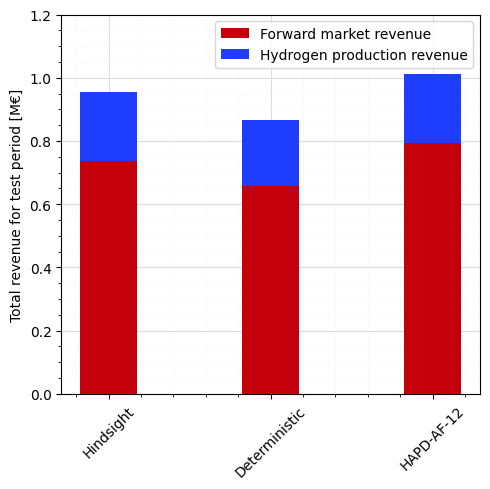

In [8]:
best_res = result_all

obj_opt = np.sum(result_opt['obj'])
obj_det = np.sum(result_det['obj'])
obj_best = np.sum(best_res['obj'])

forward_opt = np.sum([result_opt['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (result_opt['forward_bid'][i] > 0)])
forward_det = np.sum([result_det['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (result_det['forward_bid'][i] > 0)])
forward_best = np.sum([best_res['forward_bid'][i]*prices_F[t] for i, t in enumerate(range(idx_start, idx_end))  if (best_res['forward_bid'][i] > 0)])

hprod_opt = np.sum([result_opt['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])
hprod_det = np.sum([result_det['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])
hprod_best = np.sum([best_res['h_prod'][i]*price_H for i, t in enumerate(range(idx_start, idx_end))])

def dist_plot():

    xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12"]
    values = np.array([
        forward_opt,
        forward_det,
        forward_best
    ])

    hydrogens = np.array([
        hprod_opt,
        hprod_det,
        hprod_best
    ])

    values *= 1/1e6
    hydrogens *= 1/1e6

    xs = range(len(values))
    width = 0.35
    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.bar(xs, values, width, color=red, label="Forward market revenue")
    ax.bar(xs, hydrogens, width, bottom=values, color=blue, label="Hydrogen production revenue")
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xticks(xs)
    ax.set_ylabel("Total revenue for test period [M€]")
    ax.set_ylim(0, 1.2)
    fig.show()
    fig.tight_layout()
    ax.legend()
    return fig, ax

def result_plot():

    xlabels = ["Hindsight", "Deterministic", "HAPD-AF-12"]
    values = np.array([
        obj_opt,
        obj_det,
        obj_best,
    ])

    values *= 1/1e6

    xs = range(len(values))
    width = 0.35
    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.bar(xs, values, width, color=red, label="Final revenue")
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xticks(xs)
    ax.set_ylabel("Total revenue for test period [M€]")
    ax.set_ylim(0, 3.2)
    fig.show()
    fig.tight_layout()
    ax.legend()
    return fig, ax

fig, ax = dist_plot()
figres, axres = result_plot()

# fig.savefig("./pdfs/red_elec_dist.pdf")
# figres.savefig("./pdfs/red_elec_res")